In [87]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

## FSAE Acceleration Event Simulation

This model assumes simple friciton for tire friction

In [88]:
def motor_torque(rot_speed, voltage, current, efficiency, max_power=80e+3):
    max_speed = voltage*12.5 * 2*np.pi/60
    torque = 0.75*current #TODO add actual torque curve here
    #limit the torque to keep power below max
    if rot_speed >= max_speed:
        return 0
    elif torque*rot_speed > max_power:
        return efficiency*max_power/rot_speed
    else:
        return efficiency*torque

def drag_acc(speed, cda, mass, rho = 1.15):
    return (1/2) * rho * cda * speed**2 / mass
    
def max_tire_acc(rear_mass_ratio, wheelbase, cg_height, mu, g):
    return mu*rear_mass_ratio*g*wheelbase / (wheelbase-cg_height)

def max_motor_acc(mass, vehicle_speed, drive_ratio, tire_radius, voltage, current, efficiency):
    motor_speed = drive_ratio*vehicle_speed/tire_radius
    torque = motor_torque(motor_speed, voltage, current, efficiency)
    return torque*drive_ratio / tire_radius / mass
    


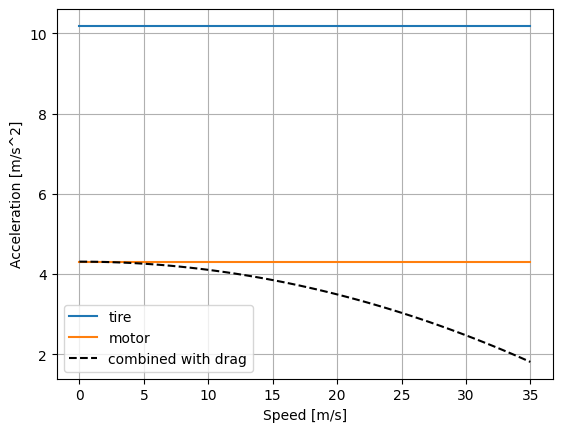

In [89]:
car = {
    'mass' : 240+70,
    'wheelbase': 1530e-3, # m
    'rear_mass_ratio': 0.57, # From Rough_Asm solidworks model
    'center_of_mass_height': 270e-3, # m From Rough_Asm solidworks model
    'mu' : 1.5,
    'drive_ratio' : 2.2,
    'tire_radius' : 210e-3,
    'cda' : 1.1,
    'drivetrain_eff' : 0.85,
    'voltage' : 72*4.0, #This is a bit lower than max voltage to account for voltage sag
    'current' : 200
}

# wrapper function for maximum vehicle acceleration at speed
def acceleration(speed, drive_ratio=car['drive_ratio'], battery_voltage=car['voltage'], max_current=car['current']):
    a_tire = max_tire_acc(car['rear_mass_ratio'], car['wheelbase'], car['center_of_mass_height'], car['mu'], 9.81)
    a_motor = max_motor_acc(car['mass'], speed, drive_ratio, car['tire_radius'], battery_voltage, max_current, car['drivetrain_eff'])
    return np.min([a_tire, a_motor]) - drag_acc(speed, car['cda'], car['mass'])              

speed_range = np.linspace(0,35)
plt.plot(speed_range, [max_tire_acc(car['rear_mass_ratio'], car['wheelbase'], car['center_of_mass_height'], car['mu'], 9.81) for speed in speed_range], label='tire')
plt.plot(speed_range, [max_motor_acc(car['mass'], speed, car['drive_ratio'], car['tire_radius'], car['voltage'], car['current'], car['drivetrain_eff']) for speed in speed_range], label='motor' )
plt.plot(speed_range, [acceleration(speed) for speed in speed_range], label='combined with drag', color='black', linestyle='--' )
plt.xlabel('Speed [m/s]')
plt.ylabel('Acceleration [m/s^2]')
plt.grid()
plt.legend()

### Simulate full event

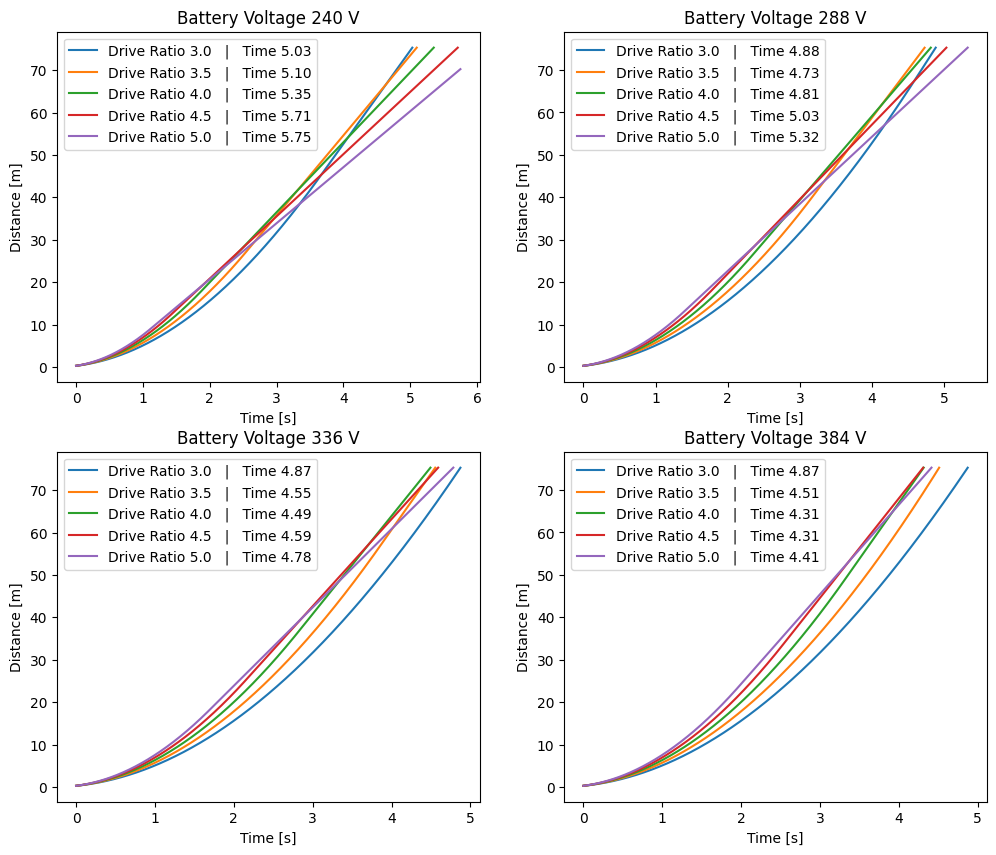

In [98]:
drive_ratios = np.linspace(3, 5, num=5)
voltages = 4*np.array([60, 72, 84, 96])

#wrapper function to simulate different drive ratios
def simulate_acc(ratio, voltage):
    def func(t, x):
        x, x_dot = x
        return [x_dot, acceleration(x_dot, drive_ratio=ratio, battery_voltage=voltage)]
        #return [x_dot, 5-0.1*x_dot**2]

    output = solve_ivp(func, [0, 6], [0,0], max_step = 0.001)
    times = output.t
    x, v = output.y

    # Find indices where x is closest to 0.3 and 75.3
    idx_start = np.argmin(np.abs(x - 0.3))
    idx_end = np.argmin(np.abs(x - 75.3))
    times = times[idx_start:idx_end] - times[idx_start]
    x = x[idx_start:idx_end]
    v = v[idx_start:idx_end]
    return times, x

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, v in zip(axes, voltages):
    for dr in drive_ratios:
        times, x = simulate_acc(dr, v)
        ax.plot(times, x, label = f'Drive Ratio {dr}   |   Time {times[-1]:.2f}')
        ax.set_title(f'Battery Voltage {v} V')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Distance [m]')
        ax.legend()

    #print(f'Final time = {times[-1]} s')



